# Classification Neural Network

We build a multi-class classification ANN (Artificial Neural Network) that we'll train to predict the true values of hand-written digits from the famous **MNIST** database


## Loading our dataset

We load data from the famous MNIST dataset for handwritten digits for numbers 0-9


In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# Training data
training_data = datasets.MNIST(
    root="data",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    target_transform=transforms.Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(
            dim=0, index=torch.tensor(y), value=1
        )
    ),
)
# Testing data
test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=transforms.ToTensor(),
    download=True,
    # Convert our labels from scalars to 0 filled tensors with a 1 at the index of the value of our label
    # i.e tensor(5) -> tensor([0,0,0,0,0,1,0,0,0,0])
    target_transform=transforms.Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(
            dim=0, index=torch.tensor(y), value=1
        )
    ),
)

## Let's visualise our data using `matplotlib`


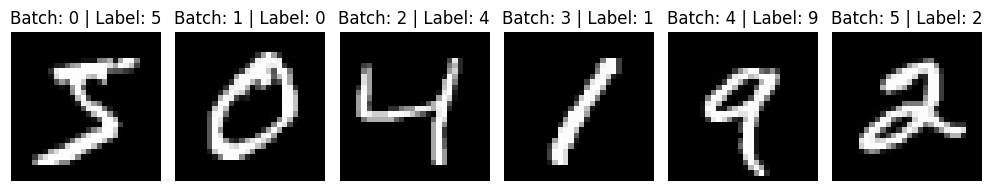

In [6]:
def visualize_mnist(dataset, num_images):
    # Get the first 'num_images' samples from the dataset
    images = dataset.data[:num_images]
    labels = dataset.targets[:num_images]

    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 3))

    for i, (image, label) in enumerate(zip(images, labels)):
        # Plot the image on the corresponding subplot
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Batch: {i} | Label: {label}")
        axes[i].axis("off")

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.show()


# Visualize the first 6 samples from the train dataset
visualize_mnist(training_data, num_images=6)

## Prepare our data for training with data loaders

**Note**: Each batch in the dataloaders is a python list of 2 elements. The first element is a tensor of images of size (64,1,28,28). Meaning it is a 4D tensor containing 64 3D tensors of images. Now the second element of the batch is a tensor of labels. Each label is of size 10. So the overall shape of this tensor is (64,10)


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64, 10])


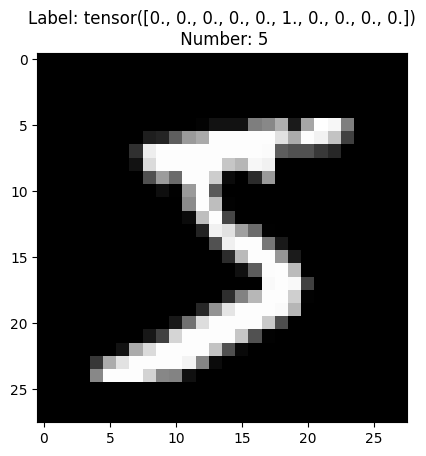

In [7]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

train_images = None
train_labels = None


for batch in train_dataloader:
    train_images = batch[0]
    train_labels = batch[1]
    break

print(f"Feature batch shape: {train_images.shape}")
print(f"Labels batch shape: {train_labels.shape}")

# Get the first image tensor and its corresponding label of the first batch
img = train_images[0].squeeze()
label = train_labels[0]

# Get the value of the label using index of the 1 value
index = torch.where(label == 1)[0].item()

plt.imshow(img, cmap="gray")
plt.title(f"Label: {label}\n Number: {index}")
plt.show()

# Make our Model


In [8]:
class DigiNet(nn.Module):
    def __init__(self):
        super(DigiNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Instantiate our model
model = DigiNet()

learning_rate = 0.01

# Define our loss function
loss_fn = nn.CrossEntropyLoss()

# Define our optimiser
optimiser = optim.SGD(params=model.parameters(), lr=learning_rate)

## Train our Model


In [68]:
def train_model(model, dataloader, loss_fn, optimiser):
    for batch_no, batch in enumerate(dataloader):
        # Define our images and labels for this batch
        images = batch[0]
        labels = batch[1]

        # Forward pass and Calculate loss
        pred = model(images)
        loss = loss_fn(pred, labels)

        # Back prop and zero grad
        optimiser.zero_grad()
        loss.backward()

        # Update our parameters
        optimiser.step()

        if batch_no % 100 == 0:
            print(f"Loss: {loss} | {batch_no}/{len(dataloader)}")


epochs = 100

model.train()
for epoch in range(epochs):
    print(f"\n Epoch: {epoch}\n --------------------")
    train_model(model, train_dataloader, loss_fn, optimiser)


 Epoch: 0
 --------------------
Loss: 0.034587178379297256 | 0/938
Loss: 0.08521167188882828 | 100/938
Loss: 0.052813589572906494 | 200/938
Loss: 0.06603704392910004 | 300/938
Loss: 0.03619798272848129 | 400/938
Loss: 0.06528518348932266 | 500/938
Loss: 0.046901118010282516 | 600/938
Loss: 0.0899745300412178 | 700/938
Loss: 0.0858767181634903 | 800/938
Loss: 0.10393349081277847 | 900/938

 Epoch: 1
 --------------------
Loss: 0.033696990460157394 | 0/938
Loss: 0.08291751146316528 | 100/938
Loss: 0.05160945653915405 | 200/938
Loss: 0.06210250034928322 | 300/938
Loss: 0.03443888574838638 | 400/938
Loss: 0.06266534328460693 | 500/938
Loss: 0.04584800451993942 | 600/938
Loss: 0.08682788163423538 | 700/938
Loss: 0.08523079752922058 | 800/938
Loss: 0.10029749572277069 | 900/938

 Epoch: 2
 --------------------
Loss: 0.03286467865109444 | 0/938
Loss: 0.08050549775362015 | 100/938
Loss: 0.05053357407450676 | 200/938
Loss: 0.05832897499203682 | 300/938
Loss: 0.032758887857198715 | 400/938
Loss

## Test our trained Model on a single image its never seen before


Test Loss: 0.0003641180810518563


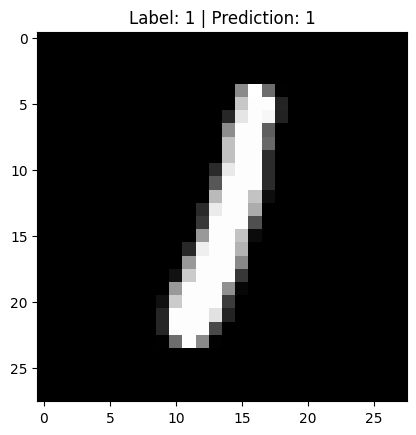

In [69]:
img = None
label = None

for batch in test_dataloader:
    img = batch[0][10]
    label = batch[1][10]
    # break

model.eval()
with torch.no_grad():
    pred = model(img)
    loss = loss_fn(pred.squeeze(), label)

index = torch.where(label == 1)[0].item()
print(f"Test Loss: {loss}")

plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Label: {index} | Prediction: {torch.argmax(pred)}")
plt.show()

## Evaluate our model's performance on a complete test dataset

We want to feed our model on brand new data and see how accurate it's predictions are


In [70]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for batch in dataloader:
            images = batch[0]
            labels = batch[1]
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            pred = np.array([torch.argmax(pred_label) for pred_label in pred])
            labels = np.array([torch.argmax(label) for label in labels])
            correct += (pred == labels).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )


test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 98.1%, Avg loss: 0.063237 



## Save our model


In [71]:
torch.save(model.state_dict(), "./DigiNet.pt")